# Risk Analysis

Demonstrate the PSL Uncertainty Calculator's Risk tool by recreating figures in "A Guard Banding Strategy for Managing False Accept" by Michael Dobbert, Agilent.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from suncal import risk

## Dobbert's Visualization

Dobbert's analysis assumes all distributions are normal. The `PFA_norm` function makes this assumption and takes TUR and in-tolerance-probability as inputs. This recreates Figure 1.

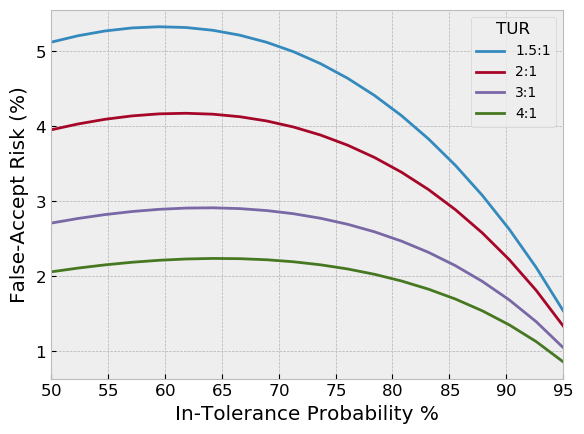

In [2]:
itplist = np.linspace(50, 95, num=20) / 100
TURlist = np.array([1.5, 2, 3, 4])

fig, ax = plt.subplots(ncols=1, figsize=(6, 4.5))

for i, TUR in enumerate(TURlist):
    PFA = np.zeros(len(itplist))
    for j, itp in enumerate(itplist):
        PFA[j] = risk.PFA_norm(itp, TUR)
    ax.plot(itplist*100, PFA*100, label='{:g}:1'.format(TUR))

ax.set_xlabel('In-Tolerance Probability %')
ax.set_ylabel('False-Accept Risk (%)')
ax.set_xlim(50, 95)
ax.legend(fontsize=10, title='TUR')
fig.tight_layout()

### Guard Banding

Figure 3 in Dobbert shows application of two different guard band techniques. These, and other guard band methods, are built in to the `PFA_norm` method by specifying strings as the GB parameter.

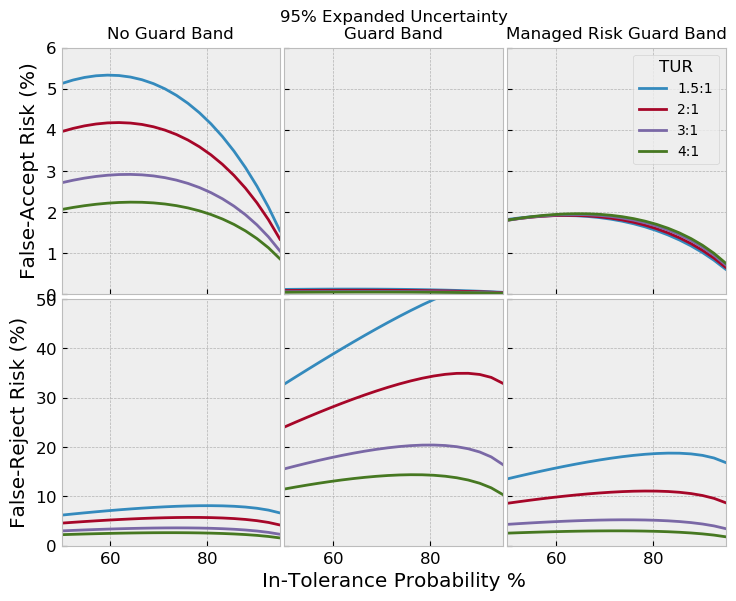

In [3]:
itplist = np.linspace(50, 95, num=20) / 100
TURlist = np.array([1.5, 2, 3, 4])

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), sharex=True)

# No guard band
for i, TUR in enumerate(TURlist):
    PFA = np.zeros(len(itplist))
    PFR = np.zeros(len(itplist))
    for j, itp in enumerate(itplist):
        PFA[j] = risk.PFA_norm(itp, TUR)
        PFR[j] = risk.PFR_norm(itp, TUR)
    axs[0][0].plot(itplist*100, PFA*100, label='{:g}:1'.format(TUR))
    axs[1][0].plot(itplist*100, PFR*100, label='{:g}:1'.format(TUR))
axs[0][0].set_title('No Guard Band', fontsize=12)

# GB 95% Test
for i, TUR in enumerate(TURlist):
    PFA = np.zeros(len(itplist))
    PFR = np.zeros(len(itplist))
    for j, itp in enumerate(itplist):
        PFA[j] = risk.PFA_norm(itp, TUR, GB='test')  # K = 1 - M/TUR, for M = 1
        PFR[j] = risk.PFR_norm(itp, TUR, GB='test')
    axs[0][1].plot(itplist*100, PFA*100, label='{:g}:1'.format(TUR))
    axs[1][1].plot(itplist*100, PFR*100, label='{:g}:1'.format(TUR))
axs[0][1].set_title('95% Expanded Uncertainty\nGuard Band', fontsize=12)

# GB Managed, Dobbert's formula
for i, TUR in enumerate(TURlist):
    PFA = np.zeros(len(itplist))
    PFR = np.zeros(len(itplist))
    for j, itp in enumerate(itplist):
        PFA[j] = risk.PFA_norm(itp, TUR, GB='dobbert')  # GB to the M = 1.04 - exp(...) formula of dobbert
        PFR[j] = risk.PFR_norm(itp, TUR, GB='dobbert')
    axs[0][2].plot(itplist*100, PFA*100, label='{:g}:1'.format(TUR))
    axs[1][2].plot(itplist*100, PFR*100, label='{:g}:1'.format(TUR))
axs[0][2].set_title('Managed Risk Guard Band', fontsize=12)

axs[0][0].set_xlim(50,95)
axs[0][0].set_ylim(0,6)
axs[0][1].set_ylim(0,6)
axs[0][2].set_ylim(0,6)
axs[1][0].set_ylim(0,50)
axs[1][1].set_ylim(0,50)
axs[1][2].set_ylim(0,50)
axs[1][1].set_xlabel('In-Tolerance Probability %')
axs[0][0].set_ylabel('False-Accept Risk (%)')
axs[1][0].set_ylabel('False-Reject Risk (%)')
axs[0][1].tick_params(labelleft=False)
axs[0][2].tick_params(labelleft=False)
axs[1][1].tick_params(labelleft=False)
axs[1][2].tick_params(labelleft=False)
axs[0][2].legend(fontsize=10, title='TUR')
fig.subplots_adjust(wspace=.02, hspace=.02)

### Other Guard banding strategies

We can make the same plot for other common guard banding strategies.

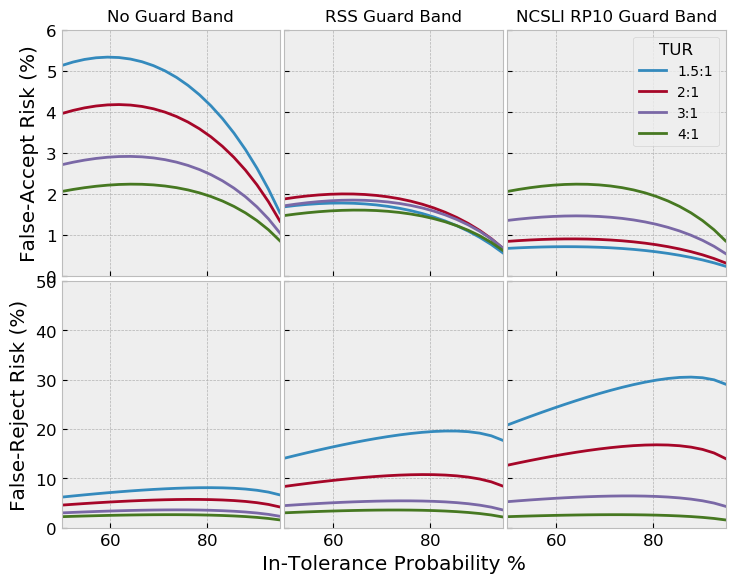

In [4]:
itplist = np.linspace(50, 95, num=20) / 100
TURlist = np.array([1.5, 2, 3, 4])

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), sharex=True)

# No guard band
for i, TUR in enumerate(TURlist):
    PFA = np.zeros(len(itplist))
    PFR = np.zeros(len(itplist))
    for j, itp in enumerate(itplist):
        PFA[j] = risk.PFA_norm(itp, TUR)
        PFR[j] = risk.PFR_norm(itp, TUR)
    axs[0][0].plot(itplist*100, PFA*100, label='{:g}:1'.format(TUR))
    axs[1][0].plot(itplist*100, PFR*100, label='{:g}:1'.format(TUR))
axs[0][0].set_title('No Guard Band', fontsize=12)

# RSS Guardband (k = sqrt(1-1/tur**2))
for i, TUR in enumerate(TURlist):
    PFA = np.zeros(len(itplist))
    PFR = np.zeros(len(itplist))
    for j, itp in enumerate(itplist):
        PFA[j] = risk.PFA_norm(itp, TUR, GB='rss')
        PFR[j] = risk.PFR_norm(itp, TUR, GB='rss')
    axs[0][1].plot(itplist*100, PFA*100, label='{:g}:1'.format(TUR))
    axs[1][1].plot(itplist*100, PFR*100, label='{:g}:1'.format(TUR))
axs[0][1].set_title('RSS Guard Band', fontsize=12)

# NCSLI RP10 Recommendation
for i, TUR in enumerate(TURlist):
    PFA = np.zeros(len(itplist))
    PFR = np.zeros(len(itplist))
    for j, itp in enumerate(itplist):
        PFA[j] = risk.PFA_norm(itp, TUR, GB='rp10')
        PFR[j] = risk.PFR_norm(itp, TUR, GB='rp10')
    axs[0][2].plot(itplist*100, PFA*100, label='{:g}:1'.format(TUR))
    axs[1][2].plot(itplist*100, PFR*100, label='{:g}:1'.format(TUR))
axs[0][2].set_title('NCSLI RP10 Guard Band', fontsize=12)

axs[0][0].set_xlim(50,95)
axs[0][0].set_ylim(0,6)
axs[0][1].set_ylim(0,6)
axs[0][2].set_ylim(0,6)
axs[1][0].set_ylim(0,50)
axs[1][1].set_ylim(0,50)
axs[1][2].set_ylim(0,50)
axs[1][1].set_xlabel('In-Tolerance Probability %')
axs[0][0].set_ylabel('False-Accept Risk (%)')
axs[1][0].set_ylabel('False-Reject Risk (%)')
axs[0][1].tick_params(labelleft=False)
axs[0][2].tick_params(labelleft=False)
axs[1][1].tick_params(labelleft=False)
axs[1][2].tick_params(labelleft=False)
axs[0][2].legend(fontsize=10, title='TUR')
fig.subplots_adjust(wspace=.02, hspace=.02)

## Guard band methods

Another visualization of guard band methods was presented in "A study of and recommendations for applying the false acceptance risk specification of Z504.3" by David Deaver. Here, a constant in-tolerance-probability of 95% is assumed while sweeping the TUR. The dotted lines represent constant guard band factors, while other guard band methods are compared. We also add the corresponding false-reject probability plot.

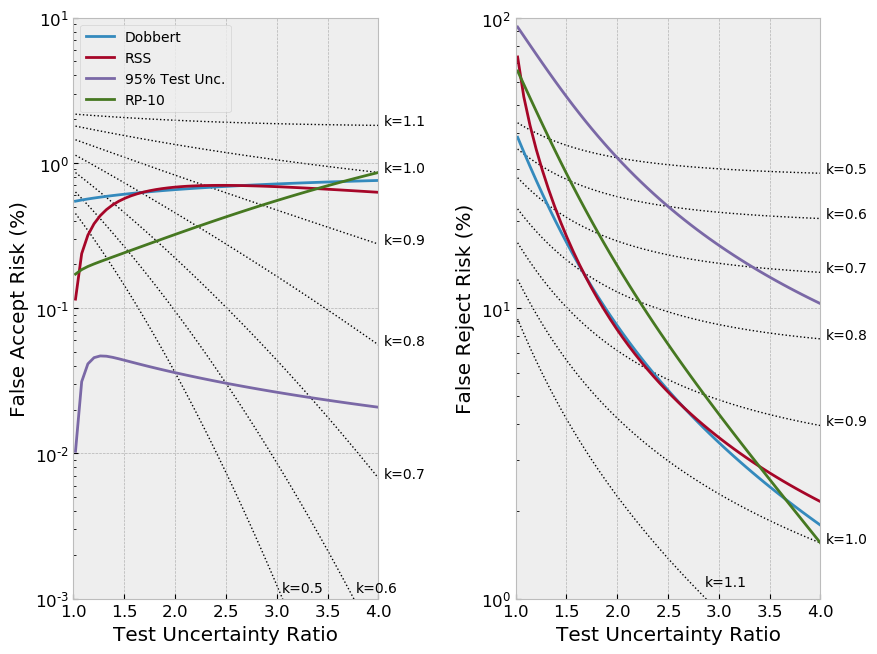

In [5]:
TURs = np.linspace(1.02,4)

pfa_dobbert = np.zeros_like(TURs)
pfa_rss = np.zeros_like(TURs)
pfa_sigtest = np.zeros_like(TURs)
pfa_rp10 = np.zeros_like(TURs)
pfr_dobbert = np.zeros_like(TURs)
pfr_rss = np.zeros_like(TURs)
pfr_sigtest = np.zeros_like(TURs)
pfr_rp10 = np.zeros_like(TURs)

itp = 0.95  # Using 95% itp for all
for i, TUR in enumerate(TURs):
    pfa_dobbert[i] = risk.PFA_norm(itp, TUR, 'dobbert') * 100
    pfa_rss[i] = risk.PFA_norm(itp, TUR, 'rss') * 100
    pfa_rp10[i] = risk.PFA_norm(itp, TUR, 'rp10') * 100
    pfa_sigtest[i] = risk.PFA_norm(itp, TUR, 'test') * 100
    pfr_dobbert[i] = risk.PFR_norm(itp, TUR, 'dobbert') * 100
    pfr_rss[i] = risk.PFR_norm(itp, TUR, 'rss') * 100
    pfr_rp10[i] = risk.PFR_norm(itp, TUR, 'rp10') * 100
    pfr_sigtest[i] = risk.PFR_norm(itp, TUR, 'test') * 100
    
fig, ax = plt.subplots(ncols=2, figsize=(9,7))
ax[0].plot(TURs, pfa_dobbert, label='Dobbert')
ax[0].plot(TURs, pfa_rss, label='RSS')
ax[0].plot(TURs, pfa_sigtest, label='95% Test Unc.')
ax[0].plot(TURs, pfa_rp10, label='RP-10')
ax[1].plot(TURs, pfr_dobbert, label='Dobbert')
ax[1].plot(TURs, pfr_rss, label='RSS')
ax[1].plot(TURs, pfr_sigtest, label='95% Test Unc.')
ax[1].plot(TURs, pfr_rp10, label='RP-10')

ax[0].set_xlabel('Test Uncertainty Ratio')
ax[0].set_ylabel('False Accept Risk (%)')
ax[0].set_yscale('log')
ax[0].set_ylim(.001, 10)
ax[0].set_xlim(1, TURs[-1])
ax[0].legend(loc='upper left', fontsize=10)
ax[1].set_xlabel('Test Uncertainty Ratio')
ax[1].set_ylabel('False Reject Risk (%)')
ax[1].set_yscale('log')
ax[1].set_ylim(1, 100)
ax[1].set_xlim(1, TURs[-1])

# Plot constant k lines
for k in [.5, .6, .7, .8, .9, 1.0, 1.1]:
    pfa = np.zeros_like(TURs)
    pfr = np.zeros_like(TURs)
    for i, TUR in enumerate(TURs):
        pfa[i] = 100 * risk.PFA_norm(itp, TUR, k)
        pfr[i] = 100 * risk.PFR_norm(itp, TUR, k)
    ax[0].plot(TURs, pfa, ls=':', color='black', lw=1, zorder=0)
    ax[1].plot(TURs, pfr, ls=':', color='black', lw=1, zorder=0)    
    
    # Hack-ish way to get the labels to wrap around the bottom
    ybot = ax[0].get_ylim()[0]
    if pfa[-1] > ybot:
        ax[0].text(TURs[-1]+.05, pfa[-1], 'k={:.1f}'.format(k), fontsize=10)
    else:
        i = np.where(pfa<ybot)[0][0]
        ax[0].text(TURs[i]-.04, ybot*1.1, 'k={:.1f}'.format(k), fontsize=10)   
    ybot = ax[1].get_ylim()[0]
    if pfr[-1] > ybot:
        ax[1].text(TURs[-1]+.05, pfr[-1], 'k={:.1f}'.format(k), fontsize=10)
    else:
        i = np.where(pfr<ybot)[0][0]
        ax[1].text(TURs[i]-.04, ybot*1.1, 'k={:.1f}'.format(k), fontsize=10)  
fig.subplots_adjust(wspace=.45)

## Monte-Carlo Method

Next, we illustrate the Monte-Carlo method of calculating PFA and PFR. This is described in the white paper "Understanding Measurement Risk" by Michael Dobbert, Agilent, recreating Figure 2. Here, `dproc` and `dtest` can be changed to any arbitrary distribution.

PFA: 0.78%
PFR: 1.54%


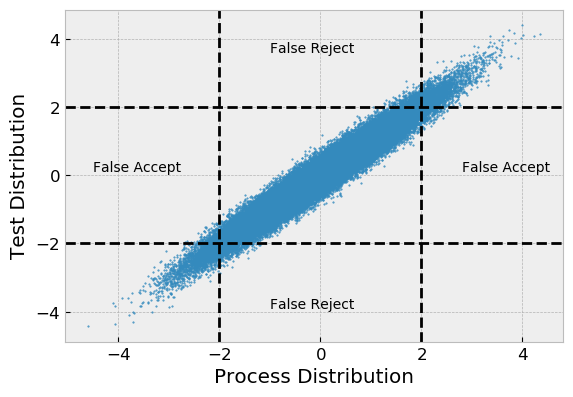

In [6]:
dproc = stats.norm(loc=0, scale=1)
dtest = stats.norm(loc=0, scale=0.25)
SL = 2
FA, FR, proc_samples, test_samples = risk.PFAR_MC(dproc, dtest, -SL, SL)
print('PFA: {:.2f}%'.format(FA*100))
print('PFR: {:.2f}%'.format(FR*100))

plt.plot(proc_samples, test_samples, marker='.', ls='', markersize=1)
plt.axvline(SL, ls='--', color='black')
plt.axvline(-SL, ls='--', color='black')
plt.axhline(SL, ls='--', color='black')
plt.axhline(-SL, ls='--', color='black')
plt.text(2.8, .1, 'False Accept', fontsize=10)
plt.text(-4.5, .1, 'False Accept', fontsize=10)
plt.text(-1, 3.6, 'False Reject', fontsize=10)
plt.text(-1, -3.9, 'False Reject', fontsize=10);
plt.xlabel('Process Distribution')
plt.ylabel('Test Distribution');

Compare the Monte-Carlo with the computing the full risk double-integral.

In [7]:
print('PFA: {:.2f}%'.format(risk.PFA(dproc, dtest, -SL, SL)*100))
print('PFR: {:.2f}%'.format(risk.PFR(dproc, dtest, -SL, SL)*100))

PFA: 0.80%
PFR: 1.49%
